# Выбор локации для скважины

**Описание проекта**

Допустим, работаем в добывающей компании «ГлавРосГосНефть».

Нам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Цель анализа: определение региона для бурения новой скважины**

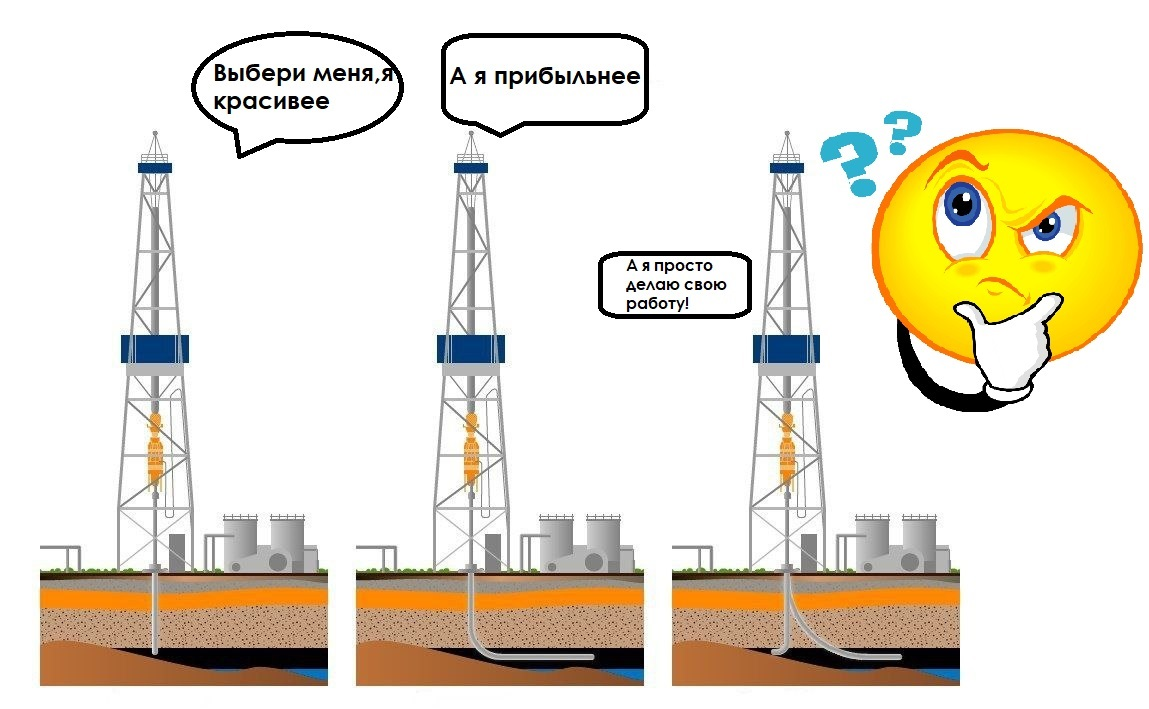

## Загрузка и подготовка данных

In [12]:
# импортирую необходимые библиотеки
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from tqdm.notebook import tqdm
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.utils import shuffle
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты  на месте
</div>


In [13]:
# открою файл csv с локалки и с обшего доступа, называем таблицы data1,data2,data3 
try:
    data1 = pd.read_csv('C:/Users/Жанат/Desktop/notebooks/8_sprint/geo_data_0.csv')
    data2 = pd.read_csv('C:/Users/Жанат/Desktop/notebooks/8_sprint/geo_data_1.csv')
    data3 = pd.read_csv('C:/Users/Жанат/Desktop/notebooks/8_sprint/geo_data_2.csv')
except:
    data1 = pd.read_csv('/datasets/geo_data_0.csv')
    data2 = pd.read_csv('/datasets/geo_data_1.csv')
    data3 = pd.read_csv('/datasets/geo_data_2.csv')
    

In [14]:
# выведу 1 таблицу data0
print(data1.head(15), '\n*********************')
# проверю общую информацию и размеры таблицы
print(data1.info(),'\n*********************')
print(data1.shape,'\n*********************')
print(data1.describe())

       id        f0        f1        f2     product
0   txEyH  0.705745 -0.497823  1.221170  105.280062
1   2acmU  1.334711 -0.340164  4.365080   73.037750
2   409Wp  1.022732  0.151990  1.419926   85.265647
3   iJLyR -0.032172  0.139033  2.978566  168.620776
4   Xdl7t  1.988431  0.155413  4.751769  154.036647
5   wX4Hy  0.969570  0.489775 -0.735383   64.741541
6   tL6pL  0.645075  0.530656  1.780266   49.055285
7   BYPU6 -0.400648  0.808337 -5.624670   72.943292
8   j9Oui  0.643105 -0.551583  2.372141  113.356160
9   OLuZU  2.173381  0.563698  9.441852  127.910945
10  b8WQ6  0.371066 -0.036585  0.009208   70.326617
11  1YYm1  0.015920  1.062729 -0.722248   45.110381
12  zIYPq -0.276476  0.924865  0.095584   89.158678
13  iqTqq  0.212696 -0.111147  5.770095  164.298520
14  Ct5yY -0.018578  0.187516  2.944683  158.633720 
*********************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype

In [15]:
# выведу 2 таблицу data1
print(data2.head(15), '\n*********************')
# проверю общую информацию и размеры таблицы
print(data2.info(),'\n*********************')
print(data2.shape,'\n*********************')
print(data2.describe())

       id         f0         f1        f2     product
0   kBEdx -15.001348  -8.276000 -0.005876    3.179103
1   62mP7  14.272088  -3.475083  0.999183   26.953261
2   vyE1P   6.263187  -5.948386  5.001160  134.766305
3   KcrkZ -13.081196 -11.506057  4.999415  137.945408
4   AHL4O  12.702195  -8.147433  5.004363  134.766305
5   HHckp  -3.327590  -2.205276  3.003647   84.038886
6   h5Ujo -11.142655 -10.133399  4.002382  110.992147
7   muH9x   4.234715  -0.001354  2.004588   53.906522
8   YiRkx  13.355129  -0.332068  4.998647  134.766305
9   jG6Gi   1.069227 -11.025667  4.997844  137.945408
10  7uHUe  11.777049  -5.334084  2.003033   53.906522
11  OXyvW  16.320755  -0.562946 -0.001783    0.000000
12  cB8re   7.736313  -6.093374  3.982531  107.813044
13  igmai   6.695604  -0.749449 -0.007630    0.000000
14  3OdkE -10.985487  -5.605994  2.991130   84.038886 
*********************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #  

In [16]:
# выведу 3 таблицу data2
print(data3.head(15), '\n*********************')
# проверю общую информацию и размеры таблицы
print(data3.info(),'\n*********************')
print(data3.shape, '\n*********************')
print(data3.describe())

       id        f0        f1        f2     product
0   fwXo0 -1.146987  0.963328 -0.828965   27.758673
1   WJtFt  0.262778  0.269839 -2.530187   56.069697
2   ovLUW  0.194587  0.289035 -5.586433   62.871910
3   q6cA6  2.236060 -0.553760  0.930038  114.572842
4   WPMUX -0.515993  1.716266  5.899011  149.600746
5   LzZXx -0.758092  0.710691  2.585887   90.222465
6   WBHRv -0.574891  0.317727  1.773745   45.641478
7   XO8fn -1.906649 -2.458350 -0.177097   72.480640
8   ybmQ5  1.776292 -0.279356  3.004156  106.616832
9   OilcN -1.214452 -0.439314  5.922514   52.954532
10  myq2g  0.628659 -2.120049  5.362437  166.799132
11  V9R1y -0.544565  0.039088  8.635293  150.859435
12  bKDo0 -0.960453 -0.127113  7.764734   96.910855
13  eXvhs  1.432891 -1.242074  3.557168    8.704162
14  wI4j3 -0.935464  2.420523  1.150536  116.829811 
*********************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype

`В значениях после запятой большое количество цифр, сокрачу значение до 4 после запятой,чтоб удобнее было работать. Проверено,что при сокращении на 2 знака происходит дублирование значений.`

In [ ]:
# таблица1
data1['f0'] = np.round(data1['f0'], decimals = 4)
data1['f1'],data1['f2'], data1['product']=np.round((data1['f1'],data1['f2'],data1['product']), decimals = 4) 
data1

In [ ]:
# таблица2
data2['f0'] = np.round(data2['f0'], decimals = 4)
data2['f1'],data2['f2'], data2['product']=np.round((data2['f1'],data2['f2'],data2['product']), decimals = 4) 
data2

In [ ]:
# таблица3
data3['f0'] = np.round(data3['f0'], decimals = 4)
data3['f1'],data3['f2'], data3['product']=np.round((data3['f1'],data3['f2'],data3['product']), decimals = 4) 
data3.head(30)

`В каждой таблице 5 столбцов по 100000 элементов. 
Указатели названия столбцов:
id — уникальный идентификатор скважины;
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
product — объём запасов в скважине (тыс. баррелей).`

`Столбец id скважины смотрится некрасиво с его хаотичными буквами, и вообще,я думаю, он нам в анализе не понадобится. Поэтому дальше я его беспощадно дропну(удалю)`

In [ ]:
data1 = data1.drop(['id'], axis=1)
data2 = data2.drop(['id'], axis=1)
data3 = data3.drop(['id'], axis=1)

In [ ]:
# проверю таблицы на дубликаты
print('Дубликатов оказалось в первой таблице:', data1.duplicated().sum())
print('Дубликатов оказалось во второй таблице:', data2.duplicated().sum())
print('Дубликатов оказалось в третьей таблице:', data3.duplicated().sum())

`Дубликатов нет, хорошо. Идем дальше`

In [ ]:
# проверю пропуски в таблицах
print('Пропусков в первой таблице:', data1.isna().sum())
print('Пропусков во второй таблице:', data2.isna().sum())
print('Пропусков в третьей таблице:', data3.isna().sum())

`Пропусков нет, отлично. Едем дальше`

`Поскольку столбец product является целевым признаком,гляну визуально на его данные`

In [ ]:
# посмотрю на гистограммы по столбцу product, использую функцию
def hist(seria, bins, xlim_max, ylim_max):
    plt.figure(figsize=[12,9])

    plt.hist(seria, bins=bins)

    plt.xlim([0,xlim_max])
    plt.ylim([0,ylim_max])

    plt.xlabel('Объем нефти на скважину, тыс. бар')
    plt.ylabel('Количество скважин')

    plt.title('Гистограмма распределения по объему скважин')
    plt.show()


In [ ]:
# вызову функцию с соответствующим столбцом каждой таблицы
# таблица1
hist(data1['product'], 150, 190, 1300)

In [ ]:
# таблица2
hist(data2['product'], 50, 80, 9000)

In [ ]:
# таблица3
hist(data3['product'], 150, 180, 1300)

In [ ]:
# проверю,что не так с таблицей 2. Здесь возможны пропуски или нулевые значения. Посмотрю на уникальные значения
print(data2['product'].value_counts(), '\n*******************')
print(data2['product'].unique())

In [ ]:
# проверю выбросы для 2 таблицы
data2.hist()
plt.show()

**Видно,что нулей много во 2 таблице, аж 8235 шт. Учитывая 100тыс элементов, получается, что нулевые значения месторождений во 2 таблице занимают около 8,2%. Причина отсутствия данных, возможно, скрывается в незаполнении ячеек, потере данных или данные месторождения не были проанализированы. Видимо, от этого вид гистограммы 2 таблицы очень подозрительный.
Оставлю пока, как есть,потом вернусь. На всякий случай, узнаем, есть ли нули в 1 и в 3 таблицах**

In [ ]:
print(data1['product'].value_counts().tail(10), '\n***************')
print(data3['product'].value_counts())
print(data1['product'].unique())

`Хорошо,что в 1 и 3 таблицах нет нулей))`

**Гистограммы 1 и 3 таблиц выглядят нормально, приблизительно схожи визуально. Нулевых значений не оказалось, поэтому можно не волноваться за них.**

## Обучение и проверка модели

**Перехожу к обучению и проверке модели. Разделю базу данных на выборки:**

В random_state укажу значение 12345. Разделю на обучающую выборку(train для обучения модели,75% исходных данных) и валидационную (valid для проверки, переобучилась ли модель,25% данных);

In [ ]:
# 2.4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.

In [ ]:
# создам функцию для разделения на выборки обуч. и валид.
def test_split(data):
    features = data.drop(['product'], axis=1) # цел.признак
    target = data['product']
    # выборки
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)
# обучение на модели линейной регрессии(вычисляет оценочные функции коэф. регрессии, прогноз весов измерения)
    model = LinearRegression()
    model.fit(features_train, target_train)
    prediction_valid = model.predict(features_valid)# прогноз
# рассчитаю показатель RMSE
    rmse = mean_squared_error(target_valid, prediction_valid)**0.5
# рассчитаю прогнозир. средний запас сырья для каждго месторождения
    mean_prediction_valid = prediction_valid.sum()/len(prediction_valid)
    return target_valid, prediction_valid, rmse, mean_prediction_valid

In [ ]:
# выведу средний запас предсказанного сырья и показатель RMSE
target_valid1, prediction_valid1, rmse1, mean_prediction_valid1 = test_split(data1)
print(f'Количество прогнозир. среднего запаса сырья в 1 месторождении: {mean_prediction_valid1} тыс.бар., RMSE: {rmse1}')
target_valid2, prediction_valid2, rmse2, mean_prediction_valid2 = test_split(data2)
print(f'Количество прогнозир. среднего запаса сырья в 2 месторождении: {mean_prediction_valid2} тыс.бар., RMSE: {rmse2}')
target_valid3, prediction_valid3, rmse3, mean_prediction_valid3 = test_split(data3)
print(f'Количество прогнозир. среднего запаса сырья в 3 месторождении: {mean_prediction_valid3} тыс.бар., RMSE: {rmse3}')

In [ ]:
# создам наглядную табличку запас и RMSE
tab_reserve_rmse = pd.DataFrame(index=['средний прогноз. запас сырья','RMSE'], 
                                columns=['1 месторождение','2 месторождение','3 месторождение'])
tab_reserve_rmse['1 месторождение'] = mean_prediction_valid1, rmse1
tab_reserve_rmse['2 месторождение'] = mean_prediction_valid2, rmse2
tab_reserve_rmse['3 месторождение'] = mean_prediction_valid3, rmse3
tab_reserve_rmse

In [ ]:
# проверка размеров выборки
#print(features_train1.shape, features_valid1.shape)
#print(features_train2.shape, features_valid2.shape)
#print(features_train3.shape, features_valid3.shape)


***Промежуточно делая вывод, можно сказать, что в 3-ем месторождении скважины хранят в себе больше всего сырья(≈ 94 т.б., показатель RMSE=40). 
В первом месторождении - сырья чуть меньше 3-го (≈ 92 т.б.,показатель RMSE=37). А вот 2 участок скважин все еще остается загадкой (≈ 68 т.б.,показатель RMSE=0.9). Конечно, на анализ сказывается отсутствие необходимых значений. И скорее всего, дальше я буду смотреть на 1 и 3 месторождения.**

## Подготовка к расчёту прибыли

Условия для расчета:
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [ ]:
# хорошо было бы вынести константы глобально, но придерживаюсь задания

# ключевые значения для расчетов прибыли сохраню в переменные
NUMBER_OBJECTS = 500 # количество исслед.объектов
BEST_NUMBER_OBJECTS = 200 # количество лучших объектов для разработки
BUDGET_REGION = 10*(10**9) # бюджет на разработку на регион составляет 10 млрд.руб,сократили на 1000,т.к. все показатели в тыс
REVENUE_ONE_BARREL = 450 # доход с 1 барреля сырья (возможно ненужная переменная)
REVENUE_UNIT_PRODUCT= 450000 # или поставить 450*10**3? доход с каждой единицы продукта,за 1000 бар, руб.


In [ ]:
# тактика такаяя: сначала рассчитаю ср.прибыль на лучшую точку
# потом расчет количества бареллей на регион и на точку в отдельности
# затем глянуть на фактические объемы запасов по месторождениям с базы данных по таблицам и сравнить их с расчетными 
# и написать вывод, укладываюсь ли я в факт?
# еще даны какие-то 500шт,тоже надо перемножить и получить прибыль....

In [11]:
#рассчитаю среднюю прибыль для каждой из избранных 200 точек
AVERAGE_PROFIT_BEST = int(BUDGET_REGION/BEST_NUMBER_OBJECTS)
print(f'Средняя прибыль на лучшей точке должна составлять: {AVERAGE_PROFIT_BEST} тыс. руб.')

# затем рассчитаю достаточный объём сырья для безубыточной разработки новой скважины, объекта
BREAKEVEN_ACTIVITY_OBJ = int(AVERAGE_PROFIT_BEST/REVENUE_UNIT_PRODUCT)
print(f'Достаточный объём сырья для безубыточной разработки новой скважины составляет: {BREAKEVEN_ACTIVITY_OBJ} тыс.бар.')

# рассчитаю достаточный объём сырья для безубыточной разработки всего региона
BREAKEVEN_ACTIVITY_REGION = int(BUDGET_REGION/REVENUE_UNIT_PRODUCT)
print(f'Достаточный объём сырья для безубыточной разработки скважин всего региона составляет: {BREAKEVEN_ACTIVITY_REGION} тыс.бар.')

NameError: name 'BUDGET_REGION' is not defined

In [ ]:
# теперь посмотрю на фактические данные с таблицы, посчитаю фактические объемы сырья на скважину и на регион
print('Средний запас сырья на скважину в 1 месторождении составляет:', f'{mean_prediction_valid1:.2f} тыс.бар.')
print('Средний запас сырья на скважину в 2 месторождении составляет:', f'{mean_prediction_valid2:.2f} тыс.бар.')
print('Средний запас сырья на скважину в 3 месторождении составляет:', f'{mean_prediction_valid3:.2f} тыс.бар.')

In [ ]:
# разница между объемами факт и расчет покажет,уложусь ли я в фактический объем. а если нет, то на сколько высоко отклонение 
deviation1 = mean_prediction_valid1 - BREAKEVEN_ACTIVITY_REGION
print(f'Отклонение от фактического объема запаса 1 месторождения составляет : {deviation1:.2f} тыс.бар.')
deviation2 = mean_prediction_valid2 - BREAKEVEN_ACTIVITY_REGION
print(f'Отклонение от фактического объема запаса 2 месторождения составляет : {deviation2:.2f} тыс.бар.')
deviation3 = mean_prediction_valid3 - BREAKEVEN_ACTIVITY_REGION
print(f'Отклонение от фактического объема запаса 3 месторождения составляет : {deviation3:.2f} тыс.бар.')

**При расчетном безубыточном показателе в 111 тыс.бар.,видно, что отклонения 1 и 3 месторождений приблизительно равны(-22129т.б против -22127т.б). 2 участок опять выделяется, но не намного. Исходя из показателей отклонений можно сказать, что есть вероятность поработать с 1 и 3 участками, и возможно, они могут принести прибыль. Но риски есть!**

## Расчёт прибыли и рисков 

**Т.к. компания планирует пустить бюджет на 200 лучших скважин, то выберу из предсказанных значений 200 макс.значений, 
суммирую их и умножу на цену/доход с каждой единицы продукта REVENUE_UNIT_PRODUCT. Тем самым получу прогнозир.прибыль с этих 200 лучших скважин. Затем нужно будет вычесть сумму выделенного бюджета из полученной величины. Если полученный показатель будет выше 0,то прибыль положительная. Если меньше 0-прибыль отрицательная.**

In [ ]:
#создам функцию.которая посчитает все вышесказанное
def fun_calculation(predict, target, count):
    sorting = pd.Series(predict, index=target.index).sort_values(ascending=False)
    sum_values_max200 = sorting[:200].sum()
    profit_200=sum_values_max200*REVENUE_UNIT_PRODUCT-BUDGET_REGION
    print(f'Сумма всего запаса с 200 лучших скважин составит: {profit_200/10**6:.2f} млн.бар.')
    print(f'Прибыль с 200 лучших скважин равна: {profit_200/10**6:.2f} млн.руб.')

In [ ]:
# проверяю 1 месторождение
fun_calculation(prediction_valid1,target_valid1,200)

In [ ]:
# проверяю 2 месторождение
fun_calculation(prediction_valid2,target_valid2,200)

In [ ]:
# проверяю 3 месторождение
fun_calculation(prediction_valid3,target_valid3,200)

**Предварительно: вижу,что месторождения прибыльные. Далее применяя технику Bootstrap с 1000 выборками, найду распределение прибыли**

In [ ]:
# расчетная функция
def fun_calcul(predict, target, count):
    sorting = pd.Series(predict).sort_values(ascending=False)
    values_select = target[sorting.index][:count]
    product = values_select.sum()
    profit = product * REVENUE_UNIT_PRODUCT
    return profit - BUDGET_REGION

In [ ]:
# функция техники Bootstrap с 1000 выборками
def technic_bootstap(target,predict):
    values = []
    count=0
    state = np.random.RandomState(12345)
    prediction = pd.Series(predict, index=target.index)
    for i in range(1000):
        target_subsample = target.sample(n=500,replace=True, random_state=state)
        probs_subsample = prediction[target_subsample.index]
        values.append(fun_calcul(probs_subsample,target_subsample, 200))  
    for i in values:
        if i < 0:
            count +=1
    values = pd.Series(values)
    mean = values.mean()
    interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
# построю гистограмму распределения прибыли
    plt.title('Распределение прибыли')
    values.plot(kind="hist", grid=True, figsize=(8,5))
    plt.xlabel('Прибыль, тыс.руб')
    plt.ylabel('Количество скважин')
    plt.show()
# начало и конец интервалов    
    low_95 = values.quantile(0.025)
    high_95 = values.quantile(0.975)
# вывожу конечные данные    
    print(f'Средняя прибыль месторождения: {mean/1000:.2f} тыс.руб')
    print(f'Прибыль данного месторождения с вероятностью 95%  прогнозируется от: {low_95/1000:.2f} тыс.руб до: {high_95/1000:.2f} тыс.руб.')
    print(f'95%-ый доверительный интервал: от {interval[0]/1000:.2f} тыс.руб до {interval[1]/1000:.2f} тыс.руб')
    print(f'Вероятность убытка данного месторождения составит: {count/10}%')

In [ ]:
technic_bootstap(target_valid1,prediction_valid1)

In [ ]:
technic_bootstap(target_valid2,prediction_valid2)

In [ ]:
technic_bootstap(target_valid3,prediction_valid3)

**Вывод**


**Проведя анализ трех месторождений, прихожу к выводу:
Первичный анализ показывал,что запасов сырья недостаточно для работы с данными месторождениями. Об этом сообщили мне отклонения от среднего расчетного значения. Но обучив модель и применив технологию Bootstrap на 1000 выборках, на основании предсказаний(по линейной регрессии) я получила очень неплохие результаты.
По расчету 1 и 3 месторождения с их 200-ми лучшими скважинами прогнозируют среднюю прибыль около 400 млн.руб.
2 месторождение тоже расчетно показало хороший результат. Но я считаю,что ввиду отсутствия очень многих первоначальных значений в базе данных, данный участок нужно отложить на время,пока не поступят корректные полные данные для повторного анализа.
Исходя из всего вышеуказанного, могу сказать, что компания может присмотреться к 1 и 3 участку скважин.**